Stream-based sampling
===================

In addition to pool-based sampling, the stream-based scenario can also be implemented easily with modAL. In this case, the labels are not queried from a pool of instances. Rather, they are given one-by-one for the learner, which queries for its label if it finds the example useful. For instance, an example can be marked as useful if the prediction is uncertain, because acquiring its label would remove this uncertainty.

The executable script for this example can be [found here](https://github.com/cosmic-cortex/modAL/blob/master/examples/stream-based_sampling.py)!

To enforce a reproducible result across runs, we set a random seed.

The dataset
-----------

In this example, we are going to learn a black square on a white background. We are going to use a random forest classifier in a stream-based setting. First, let's generate some data!

In [1]:
import numpy as np

# creating the image
im_width = 500
im_height = 500
im = np.zeros((im_height, im_width))
im[100:im_width - 1 - 100, 100:im_height - 1 - 100] = 1

# create the data to stream from
X_full = np.transpose(
    [np.tile(np.asarray(range(im.shape[0])), im.shape[1]),
     np.repeat(np.asarray(range(im.shape[1])), im.shape[0])]
)
# map the intensity values against the grid
y_full = np.asarray([im[P[0], P[1]] for P in X_full])

# create the data to stream from
X_full = np.transpose(
    [np.tile(np.asarray(range(im.shape[0])), im.shape[1]),
     np.repeat(np.asarray(range(im.shape[1])), im.shape[0])]
)
# map the intensity values against the grid
y_full = np.asarray([im[P[0], P[1]] for P in X_full])

In case you are wondering, here is how this looks like! 

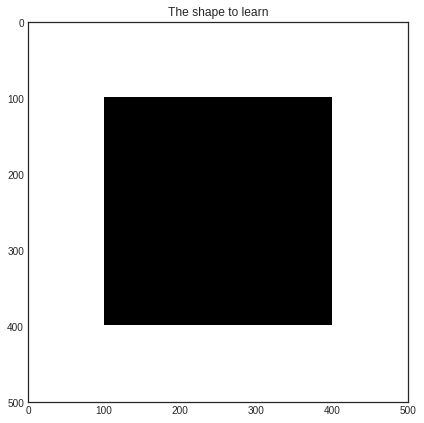

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    plt.imshow(im)
    plt.title('The shape to learn')
    plt.show()

Active learning with stream-based sampling
-----------------------------------------------------------------

For classification, we will use a random forest classifier. Initializing the learner is the same as always.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from modAL.models import ActiveLearner

# assembling initial training set
n_initial = 5
initial_idx = np.random.choice(range(len(X_full)), size=n_initial, replace=False)
X_train, y_train = X_full[initial_idx], y_full[initial_idx]

# initialize the learner
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    X_training=X_train, y_training=y_train
)
unqueried_score = learner.score(X_full, y_full)

print('Initial prediction accuracy: %f' % unqueried_score)

Initial prediction accuracy: 0.500020


/home/namazu/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Let's see how our classifier performs on the initial training set! This is how the class prediction probabilities look like for each pixel.

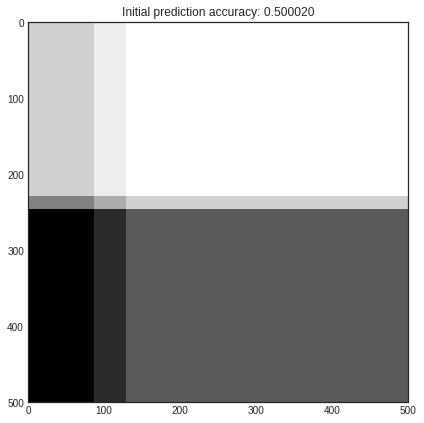

In [4]:
# visualizing initial prediciton
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = learner.predict_proba(X_full)[:, 0]
    plt.imshow(prediction.reshape(im_width, im_height))
    plt.title('Initial prediction accuracy: %f' % unqueried_score)
    plt.show()

Now we are going to randomly sample pixels from the image. If the prediction of the pixel's value is uncertain, we query the true value and teach it to the classifier. We are going to do this until we reach at least 90% accuracy.

In [5]:
from modAL.uncertainty import classifier_uncertainty

performance_history = [unqueried_score]

# learning until the accuracy reaches a given threshold
while learner.score(X_full, y_full) < 0.90:
    stream_idx = np.random.choice(range(len(X_full)))
    if classifier_uncertainty(learner, X_full[stream_idx].reshape(1, -1)) >= 0.4:
        learner.teach(X_full[stream_idx].reshape(1, -1), y_full[stream_idx].reshape(-1, ))
        new_score = learner.score(X_full, y_full)
        performance_history.append(new_score)
        print('Pixel no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Pixel no. 192607 queried, new accuracy: 0.525604
Pixel no. 249064 queried, new accuracy: 0.458388
Pixel no. 235489 queried, new accuracy: 0.596292
Pixel no. 194087 queried, new accuracy: 0.712372
Pixel no. 91580 queried, new accuracy: 0.710612
Pixel no. 199404 queried, new accuracy: 0.649388
Pixel no. 11005 queried, new accuracy: 0.767728
Pixel no. 151961 queried, new accuracy: 0.751044
Pixel no. 17891 queried, new accuracy: 0.783008
Pixel no. 117487 queried, new accuracy: 0.728964
Pixel no. 206353 queried, new accuracy: 0.836684
Pixel no. 154880 queried, new accuracy: 0.876088
Pixel no. 27770 queried, new accuracy: 0.848776
Pixel no. 194658 queried, new accuracy: 0.892492
Pixel no. 178776 queried, new accuracy: 0.943476


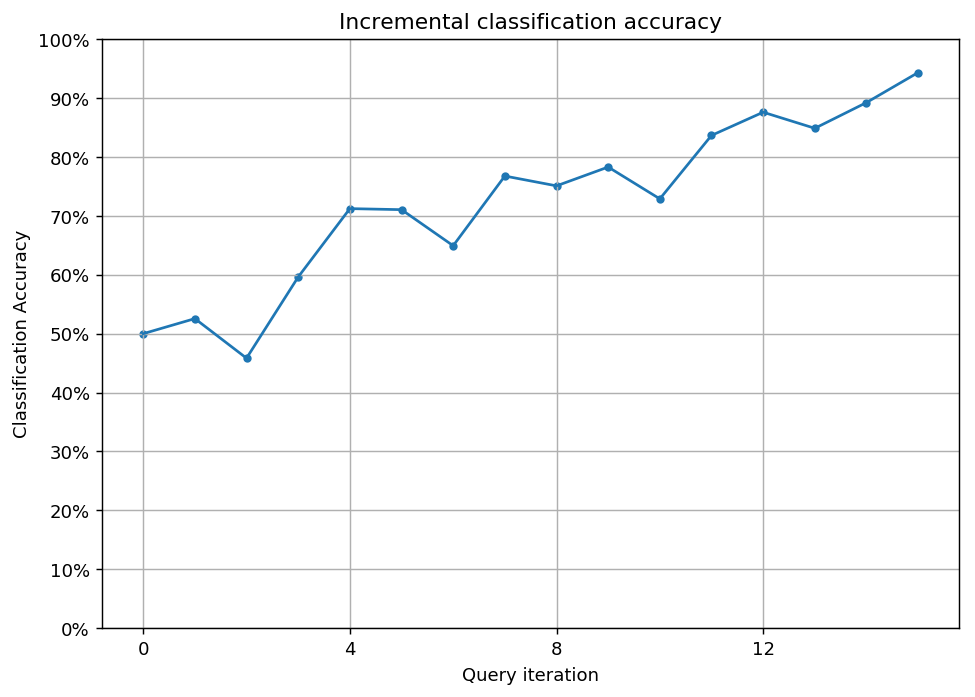

In [6]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()